<h2>Table of Contents</h2>
<p>In this lab, we will use a Convolutional Neural Network to classify handwritten digits from the MNIST database. We will reshape the images to make them faster to process </p>

<ul>
<li><a href="#Makeup_Data">Get Some Data</a></li>
<li><a href="#CNN">Convolutional Neural Network</a></li>
<li><a href="#Train">Define Softmax, Criterion function, Optimizer and Train the Model</a></li>
<li><a href="#Result">Analyze Results</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong> 14 min to train model </p>

<hr>


In [17]:


# Import the libraries we need to use in this lab

# Using the following line code to install the torchvision library
# !conda install -y torchvision

import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [18]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [19]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [20]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [21]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

## Get Some Data

In [22]:


IMAGE_SIZE = 16


composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [23]:

train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=composed)

In [24]:
# Make the validating 

validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=composed)

In [60]:
# Show the data type for each element in dataset

train_dataset[0][0].shape

torch.Size([1, 16, 16])

In [26]:
# The label for the fourth data element

train_dataset[3][1]

1

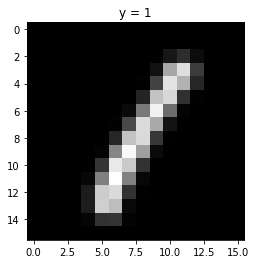

In [27]:
# The image for the fourth data element
show_data(train_dataset[3])


## Build a Convoluional Neural Network Class

In [28]:
class CNN(nn.Module):
    
    # Contructor
    def __init__(self, out_1=16, out_2=32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
    # Outputs in each steps
    def activations(self, x):
        #outputs activation this is not necessary
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0),-1)
        return z1, a1, z2, a2, out1,out

## Define the CNN Classifier, Critenrion function, Optimizer and train the model

In [30]:
# Create the model object using CNN class

model = CNN(out_1=16, out_2=32)

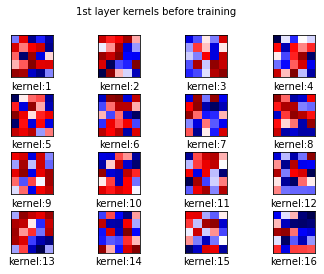

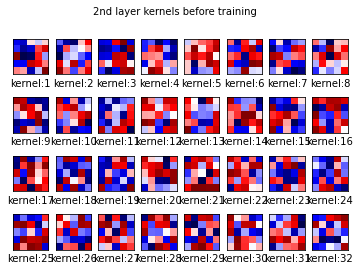

In [31]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [33]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [34]:
# Train the model

n_epochs=3
cost_list=[]
accuracy_list=[]
N_test=len(validation_dataset)
COST=0

def train_model(n_epochs):
    for epoch in range(n_epochs):
        COST=0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            COST+=loss.data
        
        cost_list.append(COST)
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
train_model(n_epochs)

<h2 id="Result">Analyze Results</h2> 


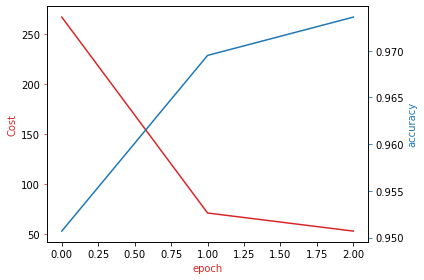

In [35]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

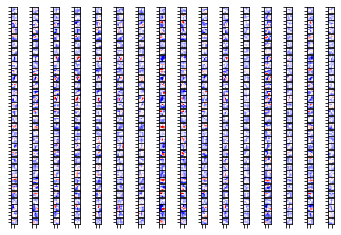

torch.Size([32, 16, 5, 5])


In [50]:
# Plot the channels

plot_channels(model.state_dict()['cnn1.weight']) #16 kernel
plot_channels(model.state_dict()['cnn2.weight']) #32kernel


In [52]:
print(model.state_dict()['cnn1.weight'].size())

torch.Size([16, 1, 5, 5])


In [53]:
print(model.state_dict()['cnn2.weight'].size())

torch.Size([32, 16, 5, 5])


In [54]:
print(model)

CNN(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)


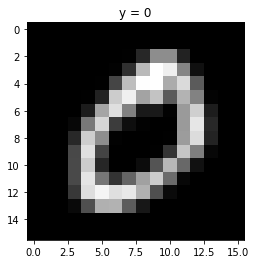

In [37]:
# Show the second image

show_data(train_dataset[1])

In [38]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

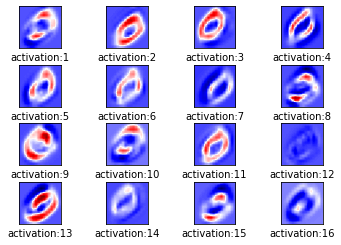

In [39]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

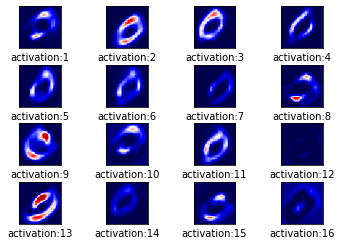

In [40]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

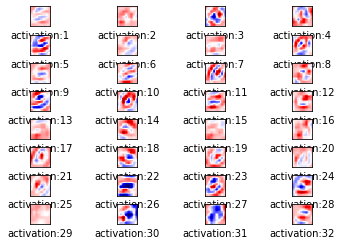

In [41]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

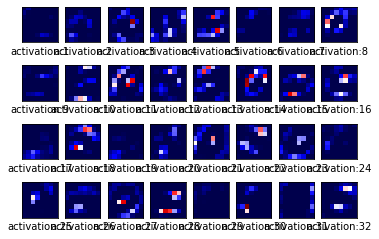

In [42]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

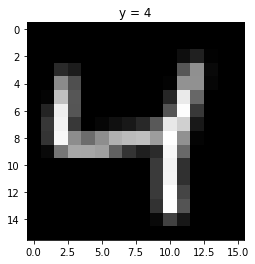

In [43]:
# Show the third image

show_data(train_dataset[2])

In [44]:
# Use the CNN activations class to see the steps

out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

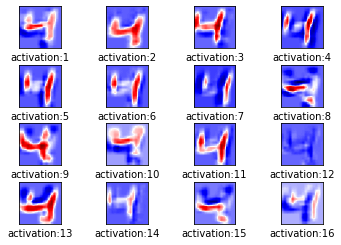

In [45]:
# Plot the outputs after the first CNN

plot_activations(out[0], number_rows=4, name="Output after the 1st CNN")

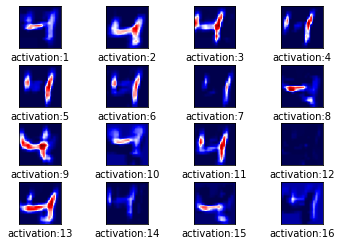

In [46]:
# Plot the outputs after the first Relu

plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

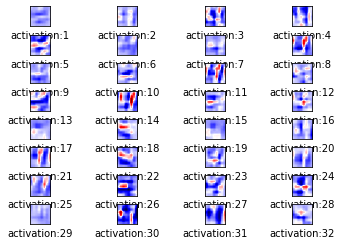

In [47]:
# Plot the outputs after the second CNN

plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

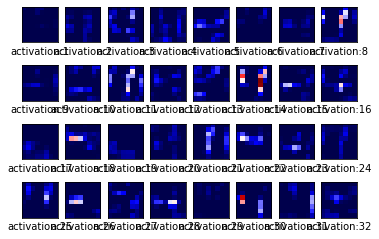

In [48]:
# Plot the outputs after the second Relu

plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

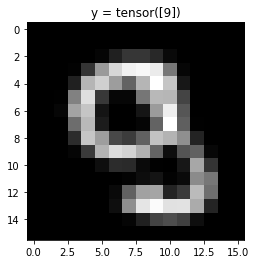

yhat:  tensor([3])


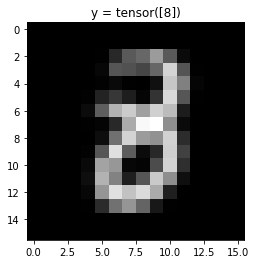

yhat:  tensor([3])


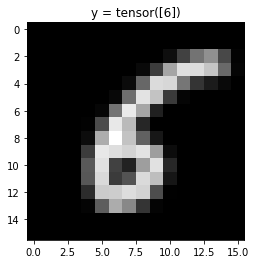

yhat:  tensor([5])


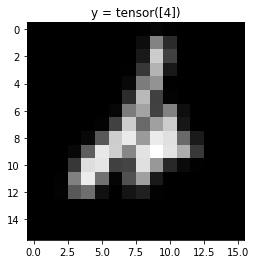

yhat:  tensor([2])


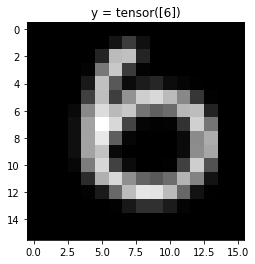

yhat:  tensor([0])


In [49]:
# Plot the mis-classified samples

count = 0
for x, y in torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1):
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data((x, y))
        plt.show()
        print("yhat: ",yhat)
        count += 1
    if count >= 5:
        break  